<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 9: Support Vector Machines

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Part 1: Classification Margins

In this lecture, we are going to cover Support Vector Machines (SVMs), one the most successful classification algorithms in machine learning.

We start the presentation of SVMs by defining the classification *margin*.

# Review: Components of A Supervised Machine Learning Problem

At a high level, a supervised machine learning problem has the following structure:

$$ \underbrace{\text{Training Dataset}}_\text{Attributes + Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

# Review: Machine Learning Models

A machine learning model is a function
$$ f : \mathcal{X} \to \mathcal{Y} $$
that maps inputs $x \in \mathcal{X}$ to targets $y \in \mathcal{Y}$.

# Review: Binary Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between two types of supervised learning problems depnding on the targets $y^{(i)}$. 

1. __Regression__: The target variable $y \in \mathcal{Y}$ is continuous:  $\mathcal{Y} \subseteq \mathbb{R}$.
2. __Binary Classification__: The target variable $y$ is discrete and takes on one of $K=2$ possible values.

In this lecture, we assume $\mathcal{Y} = \{-1, +1\}$.

# Review: Linear Model Family

In this lecture, we will work with linear models of the form:
\begin{align*}
f_\theta(x) & = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + ... + \theta_d \cdot x_d
\end{align*}
where $x \in \mathbb{R}^d$ is a vector of features and $y \in \{-1, 1\}$ is the target. The $\theta_j$ are the *parameters* of the model.

We can represent the model in a vectorized form
\begin{align*}
f_\theta(x) = \theta^\top x + \theta_0.
\end{align*}

# Notation and The Iris Dataset

In this lecture, we are going to again use the Iris flower dataset.

As we just mentioned, we make two additional assumptions:
* We will only consider binary classificaiton problems.
* We will use $\mathcal{Y} =\{-1,1\}$ as the label space.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)
iris_X, iris_y = iris.data, iris.target

# subsample to a third of the data points
iris_X = iris_X.loc[::4]
iris_y = iris_y.loc[::4]

# create a binary classification dataset with labels +/- 1
iris_y2 = iris_y.copy()
iris_y2[iris_y2==2] = 1
iris_y2[iris_y2==0] = -1

# print part of the dataset
pd.concat([iris_X, iris_y2], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,-1
4,5.0,3.6,1.4,0.2,-1
8,4.4,2.9,1.4,0.2,-1
12,4.8,3.0,1.4,0.1,-1
16,5.4,3.9,1.3,0.4,-1


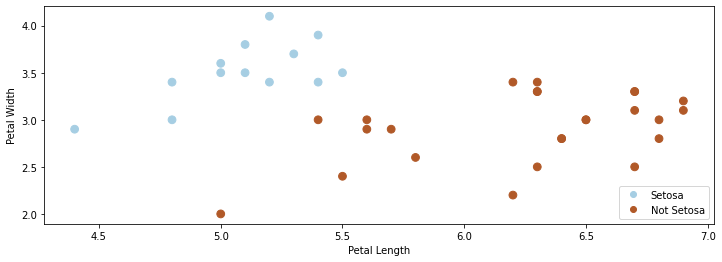

In [2]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
import warnings
warnings.filterwarnings("ignore")

# create 2d version of dataset and subsample it
X = iris_X.to_numpy()[:,:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

# Plot also the training points
p1 = plt.scatter(X[:, 0], X[:, 1], c=iris_y2, s=60, cmap=plt.cm.Paired)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Not Setosa'], loc='lower right')

# Comparing Classification Algorithms

We have seen different types approaches to classification.

When fitting a model, there may be many valid decision boundaries. How do we select one of them?

Consider the following three classification algorithms from `sklearn`. Each of them outputs a different classification boundary.

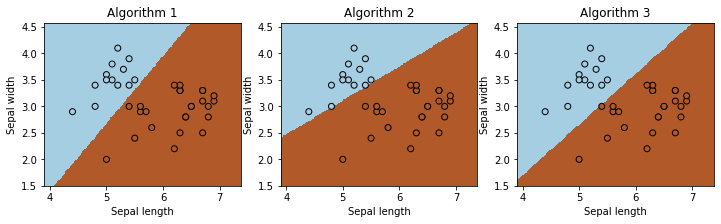

In [3]:
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
models = [LogisticRegression(), Perceptron(), RidgeClassifier()]

def fit_and_create_boundary(model):
    model.fit(X, iris_y2)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

plt.figure(figsize=(12,3))
for i, model in enumerate(models):
    plt.subplot('13%d' % (i+1))
    Z = fit_and_create_boundary(model)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired) 

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=iris_y2, edgecolors='k', cmap=plt.cm.Paired)
    plt.title('Algorithm %d' % (i+1))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

plt.show()

# Classification Scores

Most classification algorithms output not just a class label but a score.
* For example, logistic regression returns the class probability
$$ p(y=1|\mid x) = \sigma(\theta^\top x) \in [0,1] $$
If the class probability is $>0.5$, the model outputs class $1$. 

The score is an estimate of confidence; it also represents how far we are from the decision boundary.

# The Max-Margin Principle

Intuitively, we want to select boundaries with high *margin*. 

This means that we are as confident as possible for every point and we are as far as possible from the decision boundary.

Several of the separating boundaries in our previous example had low margin: they came too close to the boundary.

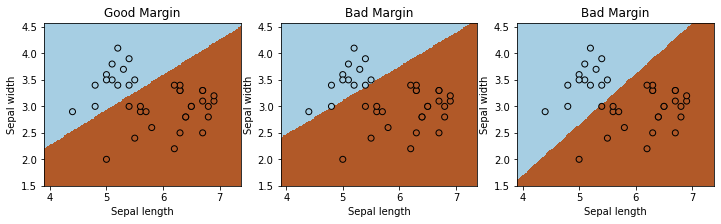

In [4]:
from sklearn.linear_model import Perceptron, RidgeClassifier
from sklearn.svm import SVC
models = [SVC(kernel='linear', C=10000), Perceptron(), RidgeClassifier()]

def fit_and_create_boundary(model):
    model.fit(X, iris_y2)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

plt.figure(figsize=(12,3))
for i, model in enumerate(models):
    plt.subplot('13%d' % (i+1))
    Z = fit_and_create_boundary(model)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired) 

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=iris_y2, edgecolors='k', cmap=plt.cm.Paired)
    if i == 0:
        plt.title('Good Margin')
    else:
        plt.title('Bad Margin')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

plt.show()

Below, we plot a decision boundary between the two classes (solid line) that has a high margin. The two dashed lines that lie at the margin.

Points that are the margin are highlighted in black. A good decision boundary is as far away as possible from the points at the margin.

(2.25, 4.0)

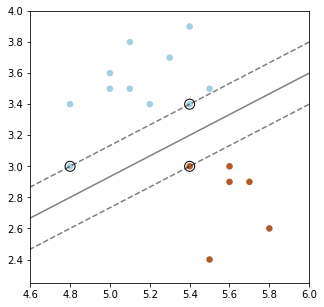

In [5]:
#https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
from sklearn import svm

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000) # we'll explain this algorithm shortly
clf.fit(X, iris_y2)

plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=iris_y2, s=30, cmap=plt.cm.Paired)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# plot decision boundary and margins
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.xlim([4.6, 6])
plt.ylim([2.25, 4])

# The Functional Classification Margin

How can we define the concept of margin more formally?

We can try to define the margin $\tilde \gamma^{(i)}$ with respect to a training example $(x^{(i)}, y^{(i)})$ as
$$ \tilde \gamma^{(i)} = y^{(i)} \cdot f(x^{(i)}) = y^{(i)} \cdot \left( \theta^\top x^{(i)} + \theta_0 \right). $$

We call this the *functional* margin. Let's analyze it.

We defined the functional margin as
$$ \tilde\gamma^{(i)} = y^{(i)} \cdot \left( \theta^\top x^{(i)} + \theta_0 \right).$$

* If $y^{(i)}=1$, then the margin $\tilde\gamma^{(i)}$ is large when the model score $f(x^{(i)}) = \theta^\top x^{(i)} + \theta_0$ is positive and large.

* Thus, we are classifying $x^{(i)}$ correctly and with high confidence.

* If $y^{(i)}=-1$, then the margin $\tilde\gamma^{(i)}$ is large when the model score $f(x^{(i)}) = \theta^\top x^{(i)} + \theta_0$ is negative and large in absolute value.

* We are again classifying $x^{(i)}$ correctly and with high confidence.

Thus higher margin means higher confidence at each input point.

However, we have a problem. 
* If we rescale the parameters $\theta, \theta_0$ by a scalar $\alpha > 0$, we get new parameters $\alpha \theta, \alpha \theta_0$ 
* The $\alpha \theta, \alpha \theta_0$ doesn't change the classification of points.
* However, the margin $\left( \alpha \theta^\top x^{(i)} + \alpha \theta_0 \right) = \alpha \left( \theta^\top x^{(i)} + \theta_0 \right)$ is now scaled by $\alpha$!

It doesn't make sense that the same classification boundary can have different margins when we rescale it.

# The Geometric Classification Margin

We define the *geometric* margin $\gamma^{(i)}$ with respect to a training example $(x^{(i)}, y^{(i)})$ as
$$ \gamma^{(i)} = y^{(i)}\left( \frac{\theta^\top x^{(i)} + \theta_0}{||\theta||} \right). $$

* We normalize the functional margin by $||\theta||$ 
* Rescaling the weights can no longer make the margin arbitrarily large, which addresses our previous issue.

Let's again make sure our intuition about the margin holds.
$$ \gamma^{(i)} = y^{(i)}\left( \frac{\theta^\top x^{(i)} + \theta_0}{||\theta||} \right). $$

* If $y^{(i)}=1$, then the margin $\gamma^{(i)}$ is large when the model score $f(x^{(i)}) = \theta^\top x^{(i)} + \theta_0$ is positive and large.

* Thus, we are classifying $x^{(i)}$ correctly and with high confidence.

* The same holds when $y^{(i)}=-1$. We again capture our intuition that increasing margin means increasing the confidence of each input point.

# Geometric Intuitions

The margin $\gamma^{(i)}$ is called geometric because it corresponds to the distance from $x^{(i)}$ to the separating hyperplane $\theta^\top x + \theta_0 = 0$ (dashed line below).

<center><img width=40% src="img/margin.png"></center>

Suppose that $y^{(i)}=1$ ($x^{(i)}$ lies on positive side of boundary). Then:
1. The points $x$ that lie on the deicision boundary are those for which $\theta^\top x + \theta_0 = 0$ (score is precisely zero, and between 1 and -1).

2. The vector $\frac{\theta}{||\theta||}$ is perpedicular to the hyperplane $\theta^\top x + \theta_0$ and has unit norm (fact from calculus).

<center><img width=40% src="img/margin.png"></center>

3. Let $x_0$ be the point on the boundary closest to $x^{(i)}$. Then by definition of the margin
$x^{(i)} = x_0 + \gamma^{(i)} \frac{\theta}{||\theta||}$ or
$$ x_0 = x^{(i)} - \gamma^{(i)} \frac{\theta}{||\theta||}. $$

4. Since $x_0$ is on the hyperplane, $\theta^\top x_0 + \theta_0 = 0$, or
$$\theta^\top \left(x^{(i)} - \gamma^{(i)} \frac{\theta}{||\theta||} \right) + \theta_0 = 0.$$

5. Solving for $\gamma^{(i)}$ and using the fact that $\theta^\top \theta = ||\theta||^2$, we obtain
$$ \gamma^{(i)} =  \frac{\theta^\top x^{(i)} + \theta_0}{||\theta||}. $$

Which is our geometric margin. The case of $y^{(i)}=-1$ can also be proven in a similar way.

We can use our formula for $\gamma$ to precisely plot the margins on our earlier plot.

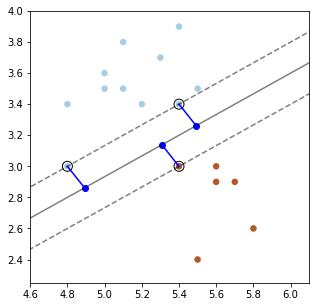

In [6]:
# plot decision boundary and margins
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=iris_y2, s=30, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.xlim([4.6, 6.1])
plt.ylim([2.25, 4])

# plot margin vectors
theta = clf.coef_[0]
theta0 = clf.intercept_
for idx in clf.support_[:3]:
    x0 = X[idx]
    y0 = iris_y2.iloc[idx]
    margin_x0 = (theta.dot(x0) + theta0)[0] / np.linalg.norm(theta)
    w = theta / np.linalg.norm(theta)
    plt.plot([x0[0], x0[0]-w[0]*margin_x0], [x0[1], x0[1]-w[1]*margin_x0], color='blue')
    plt.scatter([x0[0]-w[0]*margin_x0], [x0[1]-w[1]*margin_x0], color='blue')
plt.show()

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 2: The Max-Margin Classifier

We have seen a way to measure the confidence level of a classifier at a data point using the notion of a *margin*.

Next, we are going to see how to maximize the margin of linear classifiers.

# Review: Linear Model Family

In this lecture, we consider classification with linear models of the form:
\begin{align*}
f_\theta(x) & = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + ... + \theta_d \cdot x_d
\end{align*}
where $x \in \mathbb{R}^d$ is a vector of features and $y \in \{-1, 1\}$ is the target. The $\theta_j$ are the *parameters* of the model.

We can represent the model in a vectorized form
\begin{align*}
f_\theta(x) = \theta^\top x + \theta_0.
\end{align*}

# Review: Geometric Margin

We define the *geometric* margin $\gamma^{(i)}$ with respect to a training example $(x^{(i)}, y^{(i)})$ as
$$ \gamma^{(i)} = y^{(i)}\left( \frac{\theta^\top x^{(i)} + \theta_0}{||\theta||} \right). $$
This also corresponds to the distance from $x^{(i)}$ to the hyperplane.

# Maximizing the Margin

We want to define an objective that will result in maximizing the margin. As a first attempt, consider the following optimization problem.
\begin{align*}
\max_{\theta,\theta_0,\gamma} \gamma \; &  \\
\text{subject to } \; & y^{(i)}\frac{(x^{(i)})^\top\theta+\theta_0}{||\theta||}\geq \gamma \; \text{for all $i$} 
\end{align*}

This is maximies the smallest margin over the $(x^{(i)}, y^{(i)})$. It guarantees each point has margin at least $\gamma$.

# Maximizing the Margin

This problem is difficult to optimize because of the division by $||\theta||$ and we would like to simplify it. First, consider the equivalent problem:
\begin{align*}
\max_{\theta,\theta_0,\gamma} \gamma \; &  \\
\text{subject to } \; & y^{(i)}((x^{(i)})^\top\theta+\theta_0)\geq \gamma ||\theta|| \; \text{for all $i$}
\end{align*}

Note that this problem has an extra degree of freedom: 
* Suppose we multiply $\theta, \theta_0$ by some constant $c >0$
* This yields another valid solution!

To enforce uniqueness, we add another constraint that doesn't change the minimizer:
$$ ||\theta|| = \frac{1}{\gamma}. $$
This ensures we cannot rescale $\theta$ and also asks our linear model to assign each $x^{(i)}$ a score of at least $\pm 1$:
$$ y^{(i)}((x^{(i)})^\top\theta+\theta_0)\geq 1 \; \text{for all $i$} $$

# Maximizing the Margin

If we constraint $||\theta|| = \frac{1}{\gamma}$ holds, then we know that $\gamma = 1/\theta$ and we can replace $\gamma$ in the optimization problem to obtain:
\begin{align*}
\max_{\theta,\theta_0} \frac{1}{||\theta||} \; &  \\
\text{subject to } \; & y^{(i)}((x^{(i)})^\top\theta+\theta_0)\geq 1 \; \text{for all $i$}
\end{align*}

The solution of this problem is still the same.

# Maximizing the Margin: Final Version

Finally, instead of maximizing $1/\theta$, we can minimize $\theta$, or equvalently we can minimize $\frac{1}{2}||\theta||^2$.
\begin{align*}
\min_{\theta,\theta_0} \frac{1}{2}||\theta||^2 \; &  \\
\text{subject to } \; & y^{(i)}((x^{(i)})^\top\theta+\theta_0)\geq 1 \; \text{for all $i$}
\end{align*}

This is now a quadratic program that can be solved using off-the-shelf optimization algorithms!

# Algorithm: Linear Support Vector Machine Classification

* __Type__: Supervised learning (binary classification)
* __Model family__: Linear decision boundaries.
* __Objective function__: Max-margin optimization.
* __Optimizer__: Quadratic optimization algorithms.
* __Probabilistic interpretation__: No simple interpretation!

Later, we will see several other versions of this algorithm.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Soft Margins and the Hinge Loss

Let's continue looking at how we can maximize the margin.

# Review: Maximizing the Margin

We saw that maximizing the margin amounts to solving the following optimization problem.
\begin{align*}
\min_{\theta,\theta_0} \frac{1}{2}||\theta||^2 \; &  \\
\text{subject to } \; & y^{(i)}((x^{(i)})^\top\theta+\theta_0)\geq 1 \; \text{for all $i$}
\end{align*}

This is now a quadratic program that can be solved using off-the-shelf optimization algorithms.

# Non-Separable Problems

So far, we have assume that a linear hyperplane exists. However, what if the classes are non-separable? Then our optimization problem does not have a solution and we need to modify it.

Our solution is going to be to make each constraint "soft", by introducing "slack" variables, which allow the constraint to be violated.
$$
y^{(i)}((x^{(i)})^\top\theta+\theta_0)\geq 1 - \xi_i.
$$
* If we can classify each point with a perfect score of $\geq 1$, the $\xi_i=0$.
* If we cannot assign a perfect score, we assign a score of $1-\xi_i$.
* We define optimization such that the $\xi_i$ are chosen to be as small as possible.

In the optimization problem, we assign a penalty $C$ to these slack variables to obtain:
\begin{align*}
\min_{\theta,\theta_0, \xi}\; & \frac{1}{2}||\theta||^2 + C \sum_{i=1}^n \xi_i \;  \\
\text{subject to } \; & y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)\geq 1 - \xi_i \; \text{for all $i$} \\
& \xi_i \geq 0
\end{align*}

# Towards an Unconstainted Objective

Let's further modify things. Moving around terms in the inequality we get:
\begin{align*}
\min_{\theta,\theta_0, \xi}\; & \frac{1}{2}||\theta||^2 + C \sum_{i=1}^n \xi_i \;  \\
\text{subject to } \; & \xi_i \geq 1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right) \; \xi_i \geq 0 \; \text{for all $i$} 
\end{align*}

If $0 \geq 1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)$, we classified $x^{(i)}$ perfectly and $\xi_i = 0$

If $0 < 1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)$, then $\xi_i = 1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)$

Thus, $\xi_i = \max\left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right), 0 \right)$.

We simplify notation a bit by using the notation $(x)^+ = \max(x,0)$.

This yields:
$$\xi_i = \max\left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right), 0 \right) := \left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)\right)^+$$

# Towards an Unconstainted Objective

Since $\xi_i = \left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)\right)^+$, we can take
\begin{align*}
\min_{\theta,\theta_0, \xi}\; & \frac{1}{2}||\theta||^2 + C \sum_{i=1}^n \xi_i \;  \\
\text{subject to } \; & \xi_i \geq 1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right) \; \xi_i \geq 0 \; \text{for all $i$} 
\end{align*}

And we turn it into the following by plugging in the definition of $\xi_i$:
$$ \min_{\theta,\theta_0}\; \frac{1}{2}||\theta||^2 + C \sum_{i=1}^n \left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)\right)^+ $$

Since it doesn't matter which term we multiply by $C>0$, this is equivalent to
$$ \min_{\theta,\theta_0, \xi}\; \sum_{i=1}^n \left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)\right)^+ + \frac{\lambda}{2}||\theta||^2 $$
for some $\lambda > 0$.

# An Unconstrained Objective

We have now turned our optimizatin problem into an unconstrained form:
$$ \min_{\theta,\theta_0}\; \sum_{i=1}^n \underbrace{\left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)\right)^+}_\text{hinge loss} + \underbrace{\frac{\lambda}{2}||\theta||^2}_\text{regularizer} $$

* The hinge loss penalizes incorrect predictions.
* The L2 regularizer ensures the weights are small and well-behaved.

# The Hinge Loss

Consider again our new loss term for a label $y$ and a prediction $f$:
$$ L(y, f) = \max\left(1 - y \cdot f, 0\right). $$

* If prediction $f$ has same class as $y$, and $|f| \geq 1$, the loss is zero.
    * If class correct, no penalty if score $f$ is larger than target $y$.

* If the prediction $f$ is of the wrong class, or $|f| \leq 1$, loss is $|y - f|$.

Let's visualize a few losses $L(y=1,f)$, as a function of $f$, including hinge.

Text(0, 0.5, 'L(y=1,f)')

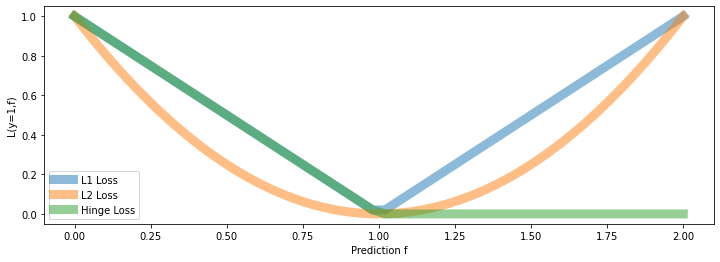

In [7]:
# define the losses for a target of y=1
hinge_loss = lambda f: np.maximum(1 - f, 0)
l2_loss = lambda f: (1-f)**2
l1_loss = lambda f: np.abs(f-1)

# plot them
fs = np.linspace(0, 2)
plt.plot(fs, l1_loss(fs), fs, l2_loss(fs), fs, hinge_loss(fs), linewidth=9, alpha=0.5)
plt.legend(['L1 Loss', 'L2 Loss', 'Hinge Loss'])
plt.xlabel('Prediction f')
plt.ylabel('L(y=1,f)')

* The hinge loss is linear like the L1 loss.
* But it only penalizes errors that are on the "wrong" side: 
    * We have an error of $|f-y|$ if true class is $1$ and $f < 1$
    * We don't penalize for predicting $f>1$ if true class is $1$.

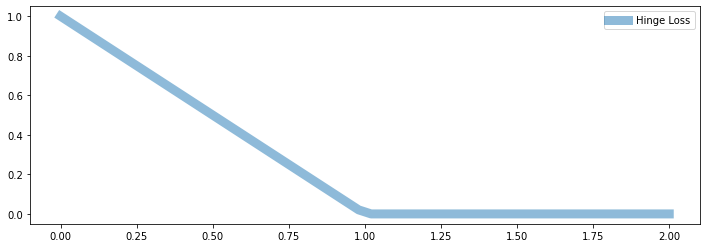

In [8]:
plt.plot(fs, hinge_loss(fs), linewidth=9, alpha=0.5)
plt.legend(['Hinge Loss'])

# Properties of the Hinge Loss

The hinge loss is one of the best losses in machine learning!
* It penalizes errors "that matter", hence is less sensitive to outliers.
* Minimizing a regularized hinge loss optimizes for a high margin.
* The loss is non-differentiable at point, which may make it more challenging to optimize.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 4: Optimization for SVMs

We have seen a new way to formulate the SVM objective. Let's now see how to optimize it.

# Review: Linear Model Family

In this lecture, we consider classification with linear models of the form:
\begin{align*}
f_\theta(x) & = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + ... + \theta_d \cdot x_d
\end{align*}
where $x \in \mathbb{R}^d$ is a vector of features and $y \in \{-1, 1\}$ is the target. The $\theta_j$ are the *parameters* of the model.

We can represent the model in a vectorized form
\begin{align*}
f_\theta(x) = \theta^\top x + \theta_0.
\end{align*}

# Review: The Hinge Loss

The hinge loss for a label $y$ and a prediction $f$ is:
$$ L(y, f) = \max\left(1 - y \cdot f, 0\right). $$

* The hinge loss is linear like the L1 loss.
* But it only penalizes errors that are on the side of the wrong class.

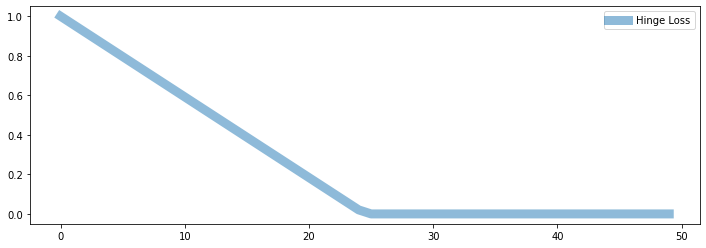

In [9]:
plt.plot(hinge_loss(fs), linewidth=9, alpha=0.5)
plt.legend(['Hinge Loss'])

# Review: SVM Objective

Maximizing the margin can be done in the following form:
$$ \min_{\theta,\theta_0, \xi}\; \sum_{i=1}^n \underbrace{\left(1 - y^{(i)}\left((x^{(i)})^\top\theta+\theta_0\right)\right)^+}_\text{hinge loss} + \underbrace{\frac{\lambda}{2}||\theta||^2}_\text{regularizer} $$

* The hinge loss penalizes incorrect predictions.
* The L2 regularizer ensures the weights are small and well-behaved.

We can easily implement this objective in `numpy`.

First we define the model.

In [10]:
def f(X, theta):
    """The linear model we are trying to fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional data matrix
    
    Returns:
    y_pred (np.array): n-dimensional vector of predicted targets
    """
    return X.dot(theta)

And then we define the objective.

In [11]:
def svm_objective(theta, X, y, C=.1):
    """The cost function, J, describing the goodness of fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return (np.maximum(1 - y * f(X, theta), 0) + C * 0.5 * np.linalg.norm(theta[:-1])**2).mean()

# Review: Gradient Descent
If we want to optimize $J(\theta)$, we start with an initial guess $\theta_0$ for the parameters and repeat the following update:
$$ \theta_i := \theta_{i-1} - \alpha \cdot \nabla_\theta J(\theta_{i-1}). $$

As code, this method may look as follows:
```python
theta, theta_prev = random_initialization()
while norm(theta - theta_prev) > convergence_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * gradient(theta_prev)
```

# A Gradient for the Hinge Loss?

What is the gradient for the hinge loss with a linear $f$?
$$ J(\theta) = \max\left(1 - y \cdot f_\theta(x), 0\right) = \max\left(1 - y \cdot \theta^\top x, 0\right). $$

Here, you see the linear part of $J$ that behaves like $1 - y \cdot f_\theta(x)$ (when $y \cdot f_\theta(x) < 1$) in orange:

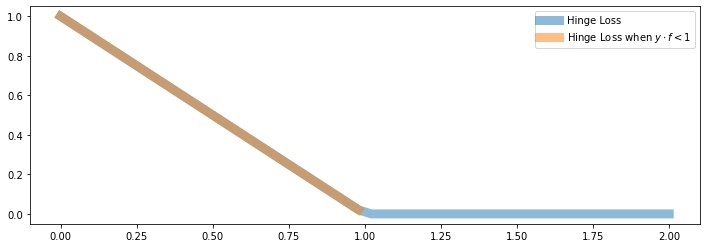

In [12]:
plt.plot(fs, hinge_loss(fs),fs[:25], hinge_loss(fs[:25]), linewidth=9, alpha=0.5)
plt.legend(['Hinge Loss', 'Hinge Loss when $y \cdot f < 1$'])

When $y \cdot f_\theta(x) < 1$, we are in the "line" part and $J(\theta)$ behaves a like $1 - y \cdot f_\theta(x)$ 

Our objective is
$$ J(\theta) = \max\left(1 - y \cdot f_\theta(x), 0\right) = \max\left(1 - y \cdot \theta^\top x, 0\right). $$
Hence the gradient in this regime is: 
$$\nabla_\theta J(\theta) = -y \cdot \nabla f_\theta(x) = -y \cdot x$$
where we used $\nabla_\theta \theta^\top x = x$.

# A Gradient for the Hinge Loss?

What is the gradient for the hinge loss with a linear $f$?
$$ J(\theta) = \max\left(1 - y \cdot f_\theta(x), 0\right) = \max\left(1 - y \cdot \theta^\top x, 0\right). $$

* When $y \cdot f_\theta(x) < 1$, we are in the "flat" part and $J(\theta) = 0$
* Hence the gradient is also just zero!

# A Gradient for the Hinge Loss?

What is the gradient for the hinge loss with a linear $f$?
$$ J(\theta) = \max\left(1 - y \cdot f_\theta(x), 0\right) = \max\left(1 - y \cdot \theta^\top x, 0\right). $$

When $y \cdot f_\theta(x) = 1$, we are in the "kink", and the gradient is not defined!
* In practice, we can either take the gradient when $y \cdot f_\theta(x) > 1$ or the gradient when $y \cdot f_\theta(x) < 1$ or anything in between. This is called the *subgradient*.

# A Steepest Descent Direction for the Hinge Loss

We can define a "gradient" like function $\tilde \nabla_\theta J(\theta)$ for the hinge loss
$$ J(\theta) = \max\left(1 - y \cdot f_\theta(x), 0\right) = \max\left(1 - y \cdot \theta^\top x, 0\right). $$
It equals:
$$\tilde \nabla_\theta J(\theta) = \begin{cases} -y \cdot x & \text{ if $y \cdot f_\theta(x) > 1$} \\ 0 & \text{ otherwise} \end{cases} $$

# Subgradient Descent for SVM

Putting this together, we obtain a complete learning algorithm, based on an optimization procedure called subgradient descent.


```python
theta, theta_prev = random_initialization()
while abs(J(theta) - J(theta_prev)) > conv_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * approximate_gradient
```

Let's implement this algorithm.

First we implement the approximate gradient.

In [13]:
def svm_gradient(theta, X, y, C=.1):
    """The (approximate) gradient of the cost function.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    
    Returns:
    subgradient (np.array): d-dimensional subgradient
    """
    yy = y.copy()
    yy[y*f(X,theta)>=1] = 0
    subgradient = np.mean(-yy * X.T, axis=1)
    subgradient[:-1] += C * theta[:-1]
    return subgradient

And then we implement subgradient descent.

In [14]:
threshold = 5e-4
step_size = 1e-2

theta, theta_prev = np.ones((3,)), np.zeros((3,))
iter = 0
iris_X['one'] = 1
X_train = iris_X.iloc[:,[0,1,-1]].to_numpy()
y_train = iris_y2.to_numpy()

while np.linalg.norm(theta - theta_prev) > threshold:
    if iter % 1000 == 0:
        print('Iteration %d. J: %.6f' % (iter, svm_objective(theta, X_train, y_train)))
    theta_prev = theta
    gradient = svm_gradient(theta, X_train, y_train)
    theta = theta_prev - step_size * gradient
    iter += 1

Iteration 0. J: 3.728947
Iteration 1000. J: 0.376952
Iteration 2000. J: 0.359075
Iteration 3000. J: 0.351587
Iteration 4000. J: 0.344411
Iteration 5000. J: 0.337912
Iteration 6000. J: 0.331617
Iteration 7000. J: 0.326604
Iteration 8000. J: 0.322224
Iteration 9000. J: 0.319250
Iteration 10000. J: 0.316727
Iteration 11000. J: 0.314800
Iteration 12000. J: 0.313181
Iteration 13000. J: 0.311843
Iteration 14000. J: 0.310667
Iteration 15000. J: 0.309561
Iteration 16000. J: 0.308496
Iteration 17000. J: 0.307523
Iteration 18000. J: 0.306614
Iteration 19000. J: 0.305768
Iteration 20000. J: 0.305068
Iteration 21000. J: 0.304293


We can visualize the results to convince ourselves we found a good boundary.

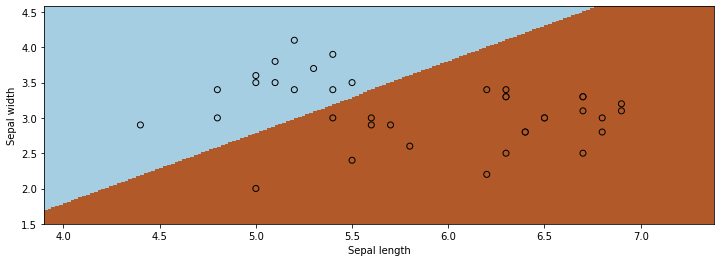

In [15]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = f(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)], theta)
Z[Z<0] = 0
Z[Z>0] = 1

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

# Algorithm: Linear Support Vector Machine Classification

* __Type__: Supervised learning (binary classification)
* __Model family__: Linear decision boundaries.
* __Objective function__: L2-regularized hinge loss.
* __Optimizer__: Subgradient descent.
* __Probabilistic interpretation__: No simple interpretation!